# Runthrough of Pawprint Pipeline So Far

This is how you import the class

In [1]:
import sys
sys.path.append('../')
import cats

from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.cmd.CMD import Isochrone
from cats.inputs import stream_inputs as inputs
from cats.proper_motions import ProperMotionSelection, rough_pm_poly

importing other stuff for this notebook

In [2]:
import numpy as np
import galstreams as gst
import gala.coordinates as gc
from astropy.coordinates import SkyCoord
import astropy.units as u
import astropy.table as at
from scipy.interpolate import InterpolatedUnivariateSpline
from matplotlib import pyplot as plt
import matplotlib as mpl
import importlib

## Simple Example: Creating a Pawprint from Galstreams

load a pawprint from galstreams (creates a sky footprint for the stream and background from the track, leaves others blank)

In [3]:
p = Pawprint.pawprint_from_galstreams('GD-1', 'pricewhelan2018', width = 2 * u.deg)
#p1 = Pawprint.pawprint_from_galstreams('GD-1','ibata2021', width = 2 * u.deg)

Text(0, 0.5, 'Distance')

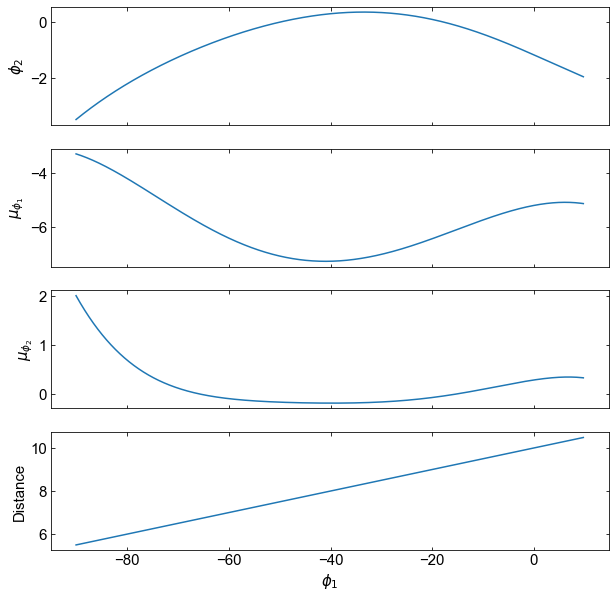

In [4]:
# Convert to stream coordinates and plot
stream_obj = p.track
stream_fr = stream_obj.stream_frame
track = stream_obj.track.transform_to(stream_fr)
gd1_track = gc.reflex_correct(track)

fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(10, 10), sharex=True)
ax1.plot(gd1_track.phi1, gd1_track.phi2)
ax2.plot(gd1_track.phi1, gd1_track.pm_phi1_cosphi2)
ax3.plot(gd1_track.phi1, gd1_track.pm_phi2)
ax4.plot(gd1_track.phi1, gd1_track.distance)
ax4.set_xlabel(r'$\phi_1$', fontsize=15)
ax1.set_ylabel(r'$\phi_2$', fontsize=15)
ax2.set_ylabel(r'$\mu_{\phi_1}$', fontsize=15)
ax3.set_ylabel(r'$\mu_{\phi_2}$', fontsize=15)
ax4.set_ylabel(r'Distance', fontsize=15)

## Creating the Full Pawprint (Making Proper Motion and CMD Cuts)

### GD-1 Proper Motion + CMD Cuts

In [5]:
stream='GD-1'

**Everything after this is completely identical for any stream. The differing initial parameters of the stream are given in a dictionary in `inputs.py`.**

We currently have only a spatial cut from galstreams. Let's make a very rough proper motion cut from the galstreams tracks and then make a CMD footprint. At the end we will output a pawprint object that can be used as the input for next steps.

In [6]:
fn = "/Users/Tavangar/CATS_workshop/cats/data/joined-{}.fits".format(inputs[stream]['short_name'])
cat = at.Table.read(fn)

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with (this comes only from the galstreams proper motion tracks)
p.pmprint = rough_pm_poly(p, buffer=2)

# Create the CMD cuts
o = Isochrone(stream, cat, pawprint=p)
_, iso_mask, _, _, _, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

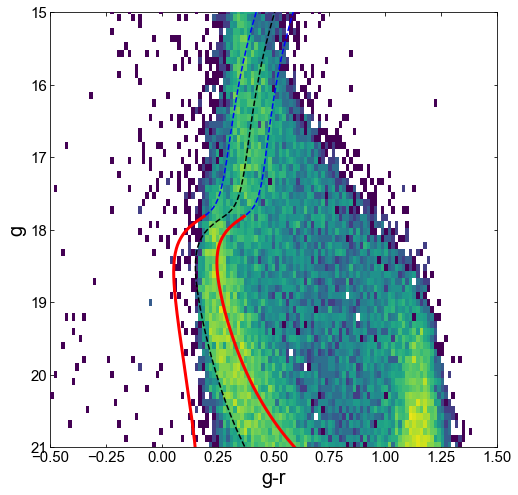

In [7]:
fig = o.plot_CMD(scale_err=2)
fig.savefig(
    "/Users/Tavangar/CATS_workshop/cats/cats/cmd/gd1_testcmd.png",
    dpi=300,
    bbox_inches="tight",
)

The above shows the CMD polygon region overlaid onto all the stars that pass the previous proper motion and spatial cuts.

Now let's use the CMD polygon to make a more refined proper motion cut. This will make a few different proper motion polygons that we will plot afterward.

-40.18182128833206
Fitting for peak pm location
Pre-fitting mean PM values: -7.273646514258676, -0.18289583777346516
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-7.34288222939898, -0.3536957835788072, 0.35139715880279015, 0.30216217880308543] 

Producing the polygon and mask


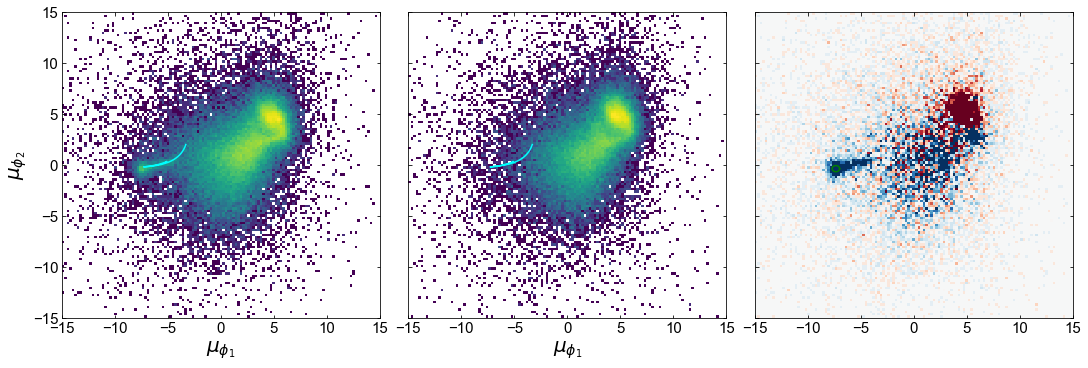

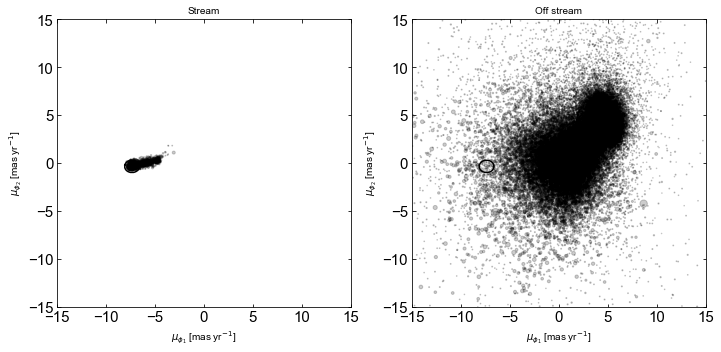

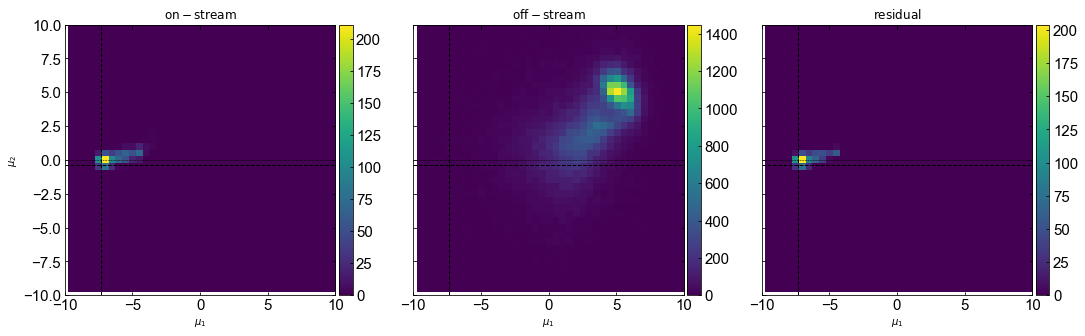

In [8]:
pmsel = ProperMotionSelection(stream, cat, pprint,
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [9]:
importlib.reload(sys.modules['cats.cmd.CMD'])
importlib.reload(sys.modules['cats.pawprint.pawprint'])
from cats.pawprint.pawprint import Pawprint, Footprint2D
from cats.cmd.CMD import Isochrone

o = Isochrone(stream, cat, pawprint=pmsel.pawprint,)

_, iso_mask, _, _, _, pprint = o.simpleSln(22, mass_thresh=0.83)

../cats/cmd/CMD.py:285: RuntimeWarning: invalid value encountered in true_divide
  signal = signal / signal_counts



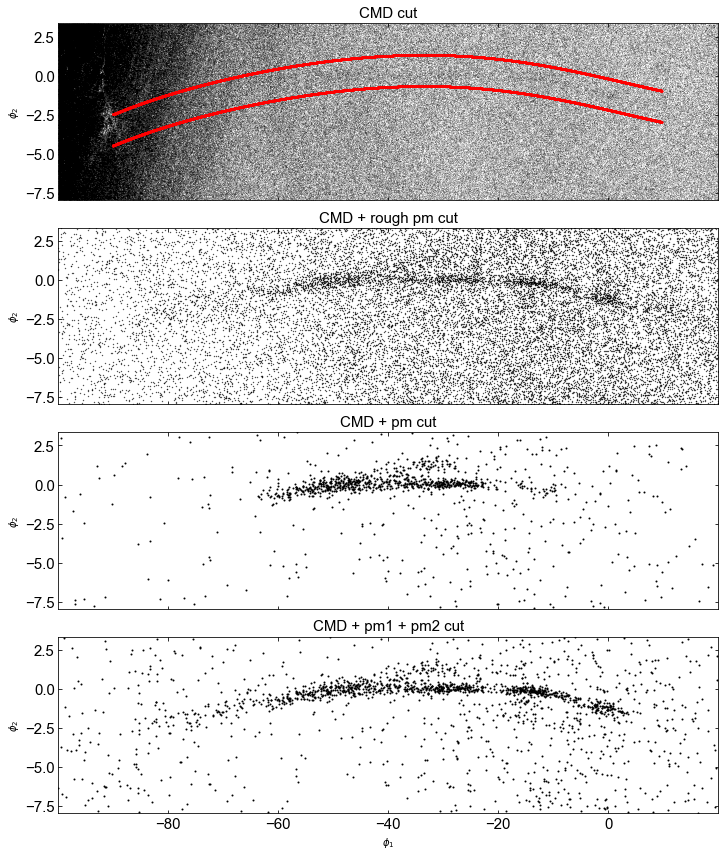

In [14]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

ax1.scatter(o.cat[iso_mask]['phi1'], 
            o.cat[iso_mask]['phi2'], s=0.001, c='k')
ax1.scatter(pprint.skyprint['stream'].vertices[:,0], 
            pprint.skyprint['stream'].vertices[:,1], s=1, c='r')
ax1.set_title('CMD cut', fontsize=15)

ax2.scatter(o.cat[pmsel.rough_pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.rough_pm_mask & iso_mask]['phi2'], s=0.1, c='k')
ax2.set_title('CMD + rough pm cut', fontsize=15)

ax3.scatter(o.cat[pmsel.pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm_mask & iso_mask]['phi2'], s=1, c='k')
ax3.set_title('CMD + pm cut', fontsize=15)

ax4.scatter(o.cat[pmsel.pm12_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm12_mask & iso_mask]['phi2'], s=1, c='k')
ax4.set_title('CMD + pm1 + pm2 cut', fontsize=15)
ax4.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
ax2.set_ylabel(r'$\phi_2$')
ax3.set_ylabel(r'$\phi_2$')
ax4.set_ylabel(r'$\phi_2$')

ax4.set_xlim(np.min(o.cat['phi1']), np.max(o.cat['phi1']))
ax1.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax2.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax3.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax4.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))

fig.tight_layout()
plt.savefig('../figures/gd1_cuts.png')
plt.show()

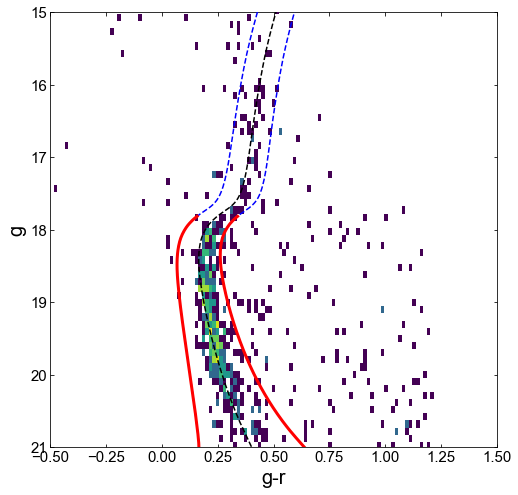

In [15]:
fig = o.plot_CMD(scale_err=2)
fig.savefig(
    "../figures/gd1_testcmd.png",
    dpi=300,
    bbox_inches="tight",
)

### Pal 5 Proper Motion + CMD Cuts

In [16]:
stream='Pal5'
fn = "/Users/Tavangar/CATS_workshop/cats/data/joined-{}.fits".format(inputs[stream]['short_name'])
cat = at.Table.read(fn)

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with
p.pmprint = rough_pm_poly(p, buffer=1)

o = Isochrone(stream, cat, pawprint=p)

_, iso_mask, _, _, _, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

-4.284660036724233
Fitting for peak pm location
Pre-fitting mean PM values: 1.2565099582469665, 0.03866860219828835
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [1.2860707024610896, 0.07392085853572819, 0.27930956609238233, 0.24385873159703655] 

Producing the polygon and mask


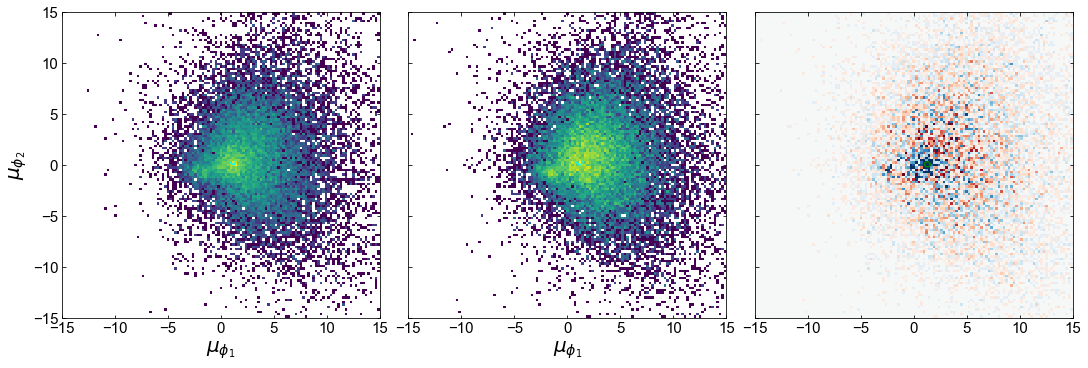

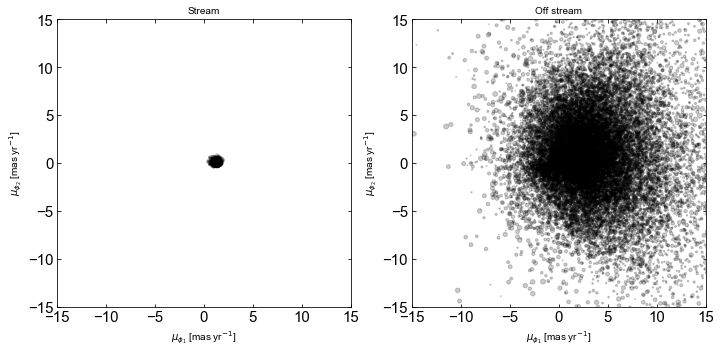

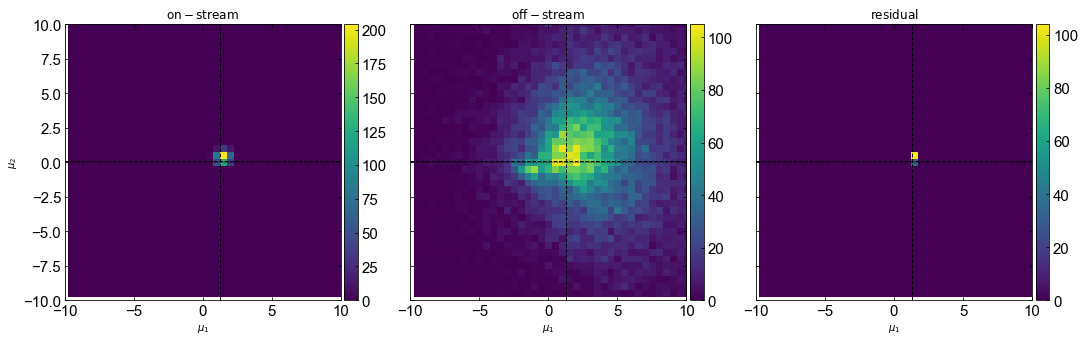

In [17]:
pmsel = ProperMotionSelection(stream, cat, pprint, 
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [18]:
o = Isochrone(stream, cat, pawprint=p)
iso_patch, iso_mask, iso_model, iso_low, iso_high, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

../cats/cmd/CMD.py:285: RuntimeWarning: invalid value encountered in true_divide
  signal = signal / signal_counts



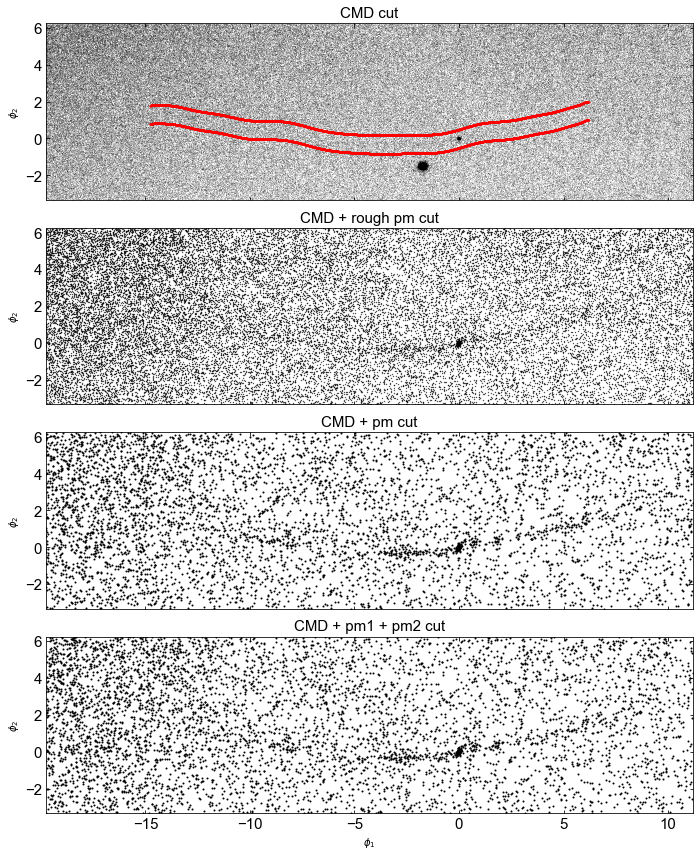

In [19]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

ax1.scatter(o.cat[iso_mask]['phi1'], 
            o.cat[iso_mask]['phi2'], s=0.001, c='k')
ax1.scatter(pprint.skyprint['stream'].vertices[:,0], 
            pprint.skyprint['stream'].vertices[:,1], s=1, c='r')
ax1.set_title('CMD cut', fontsize=15)

ax2.scatter(o.cat[pmsel.rough_pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.rough_pm_mask & iso_mask]['phi2'], s=0.1, c='k')
ax2.set_title('CMD + rough pm cut', fontsize=15)

ax3.scatter(o.cat[pmsel.pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm_mask & iso_mask]['phi2'], s=1, c='k')
ax3.set_title('CMD + pm cut', fontsize=15)

ax4.scatter(o.cat[pmsel.pm12_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm12_mask & iso_mask]['phi2'], s=1, c='k')
ax4.set_title('CMD + pm1 + pm2 cut', fontsize=15)
ax4.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
ax2.set_ylabel(r'$\phi_2$')
ax3.set_ylabel(r'$\phi_2$')
ax4.set_ylabel(r'$\phi_2$')

ax4.set_xlim(np.min(o.cat['phi1']), np.max(o.cat['phi1']))
ax1.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax2.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax3.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax4.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))

fig.tight_layout()
plt.savefig('../figures/pal5_cuts.png')
plt.show()

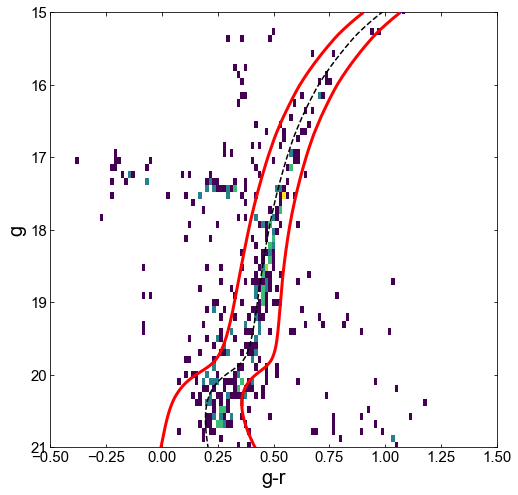

In [20]:
fig = o.plot_CMD()
fig.savefig(
    "../figures/pal5_testcmd.png",
    dpi=300,
    bbox_inches="tight",
)

## Jhelum Proper Motion and CMD Cuts

In [21]:
stream='Jhelum'
fn = "/Users/Tavangar/CATS_workshop/cats/data/joined-{}.fits".format(stream)
cat = at.Table.read(fn)

p = Pawprint.pawprint_from_galstreams(inputs[stream]['short_name'],
                                      inputs[stream]['pawprint_id'],
                                      width=inputs[stream]['width'] * u.deg)

# rough pm cut to start with
p.pmprint = rough_pm_poly(p, buffer=1)

o = Isochrone(stream, cat, pawprint=p)

_, iso_mask, _, _, _, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

2.6490062029744296e-05
Fitting for peak pm location
Pre-fitting mean PM values: -5.387718269574119, 0.10657131295596657
Post-fitting (pm1_mean, pm2_mean, pm1_std, pm2_std): [-5.724598649634675, 0.7068315675136656, 0.7859354485751061, 0.3569853511292295] 

Producing the polygon and mask


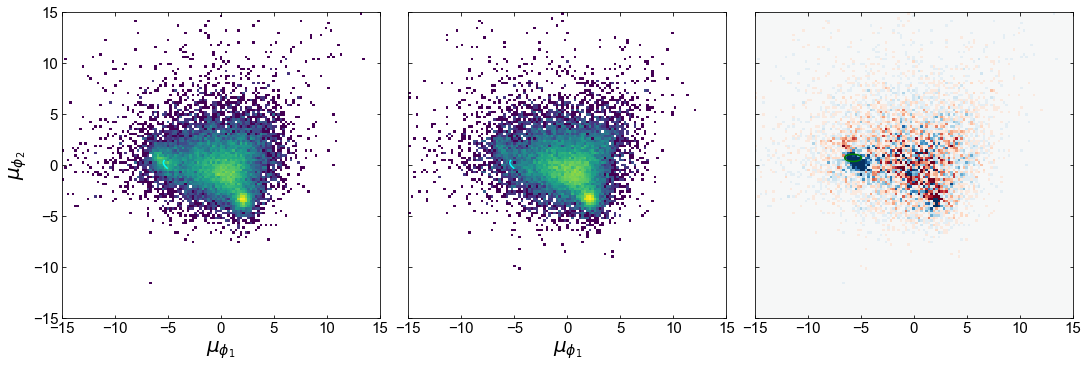

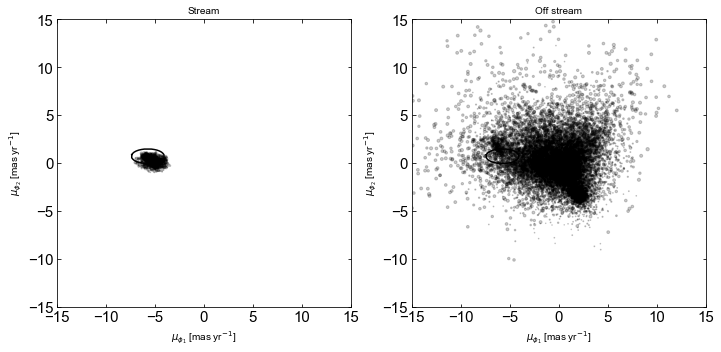

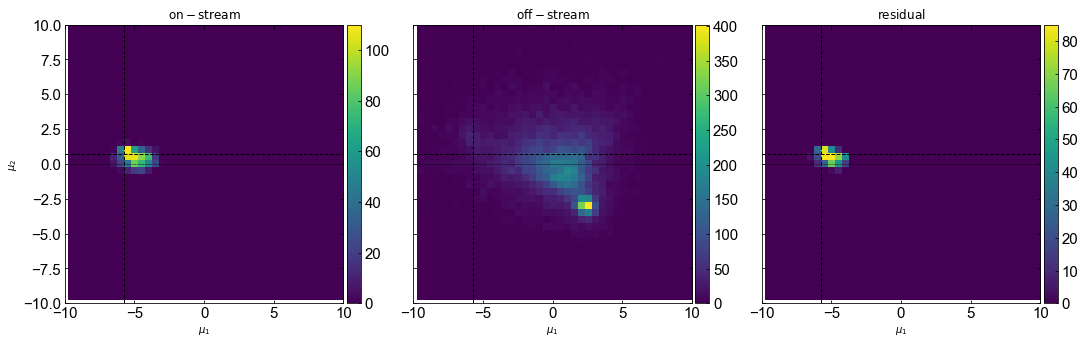

In [22]:
pmsel = ProperMotionSelection(stream, cat, pprint, 
                              n_dispersion_phi1=3, n_dispersion_phi2=3, cutoff=0.1)

In [23]:
o = Isochrone(stream, cat, pawprint=pmsel.pawprint)
_, iso_mask, iso_model, iso_low, iso_high, pprint = o.simpleSln(maxmag=22, mass_thresh=0.83)

../cats/cmd/CMD.py:285: RuntimeWarning: invalid value encountered in true_divide
  signal = signal / signal_counts



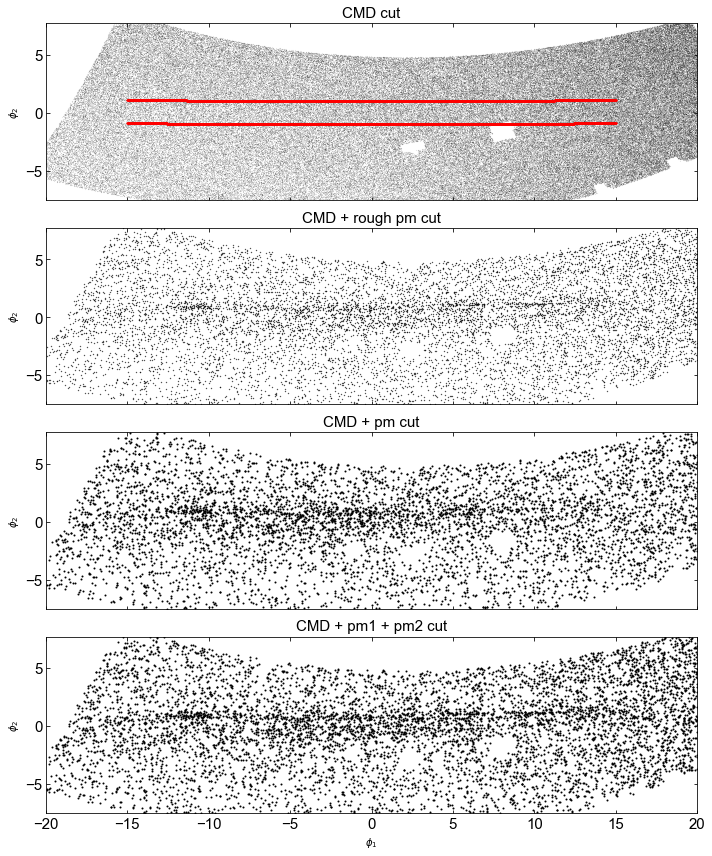

In [24]:
fig, [ax1, ax2, ax3, ax4] = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

ax1.scatter(o.cat[iso_mask]['phi1'], 
            o.cat[iso_mask]['phi2'], s=0.001, c='k')
ax1.scatter(pprint.skyprint['stream'].vertices[:,0], 
            pprint.skyprint['stream'].vertices[:,1], s=1, c='r')
ax1.set_title('CMD cut', fontsize=15)

ax2.scatter(o.cat[pmsel.rough_pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.rough_pm_mask & iso_mask]['phi2'], s=0.1, c='k')
ax2.set_title('CMD + rough pm cut', fontsize=15)

ax3.scatter(o.cat[pmsel.pm_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm_mask & iso_mask]['phi2'], s=1, c='k')
ax3.set_title('CMD + pm cut', fontsize=15)

ax4.scatter(o.cat[pmsel.pm12_mask & iso_mask]['phi1'], 
            o.cat[pmsel.pm12_mask & iso_mask]['phi2'], s=1, c='k')
ax4.set_title('CMD + pm1 + pm2 cut', fontsize=15)
ax4.set_xlabel(r'$\phi_1$')
ax1.set_ylabel(r'$\phi_2$')
ax2.set_ylabel(r'$\phi_2$')
ax3.set_ylabel(r'$\phi_2$')
ax4.set_ylabel(r'$\phi_2$')

ax4.set_xlim(np.min(o.cat['phi1']), np.max(o.cat['phi1']))
ax1.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax2.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax3.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))
ax4.set_ylim(np.min(o.cat['phi2']), np.max(o.cat['phi2']))

fig.tight_layout()
plt.savefig('../figures/jhelum_cuts.png')
plt.show()

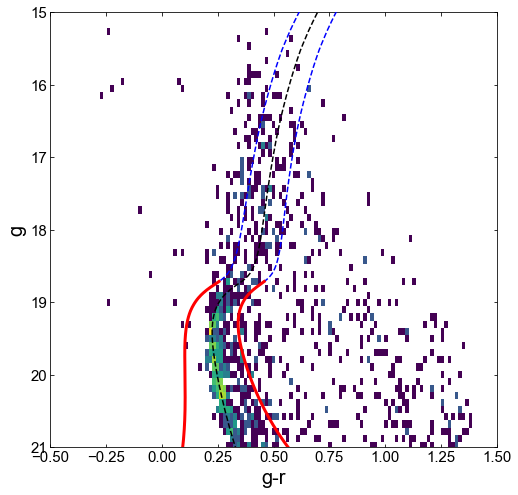

In [25]:
fig = o.plot_CMD()
fig.savefig(
    "../figures/jhelum_testcmd.png",
    dpi=300,
    bbox_inches="tight",
)

# Demo from November 2022 (now outdated)

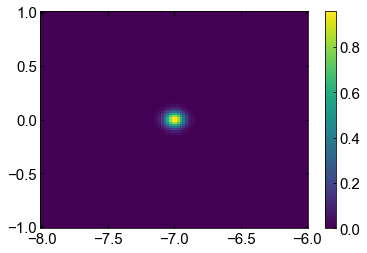

In [256]:
def two_dimensional_gaussian(x, y, x0, y0, sigma_x, sigma_y):
    """
    Evaluates a two dimensional gaussian distribution in x, y, with means x0, y0, and dispersions sigma_x and sigma_y
    """

    return np.exp(- ( (x-x0)**2/(2*sigma_x**2) + (y-y0)**2/(2*sigma_y**2) ) )

refine_factor = 100
pm_phi1_array = np.linspace(-8, -6, refine_factor)
pm_phi2_array = np.linspace(-1, 1, refine_factor)

pm_pdf = np.zeros((len(pm_phi1_array), refine_factor))
points_x = np.zeros((len(pm_phi1_array), refine_factor))
points_y = np.zeros((len(pm_phi1_array), refine_factor))

for n, s in enumerate(pm_phi1_array):
    pm_pdf[n,:] = two_dimensional_gaussian(s, pm_phi2_array, -7, 0, 0.05, 0.05)
    points_x[n,:] = np.array([s for _ in range(len(pm_phi2_array))])
    points_y[n,:] = pm_phi2_array

plt.pcolormesh(points_x, points_y, pm_pdf)
plt.colorbar()

In [257]:
from scipy.spatial import ConvexHull
cut = np.where(pm_pdf.flatten()> 0.68)[0]
x_cut = points_x.flatten()[cut]
y_cut = points_y.flatten()[cut]

xy = np.transpose([x_cut, y_cut])
hull = ConvexHull(xy)
xy = np.transpose([x_cut, y_cut])
xy[hull.vertices]

array([[-7.03030303, -0.03030303],
       [-6.96969697, -0.03030303],
       [-6.96969697,  0.03030303],
       [-7.03030303,  0.03030303]])

In [38]:
mwsts = gst.MWStreams(verbose=False, implement_Off=False)

Initializing galstreams library from master_log... 


In [84]:
GD1_track6D.track

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, kpc)
    [(123.27554451, -10.08867889,  9.19913413),
     (123.27915026, -10.07921446,  9.19864732),
     (123.2827562 , -10.06975018,  9.1981605 ), ...,
     (219.87607135,  57.91437012, 11.68099538),
     (219.89469935,  57.91254606, 11.68271884),
     (219.91332539,  57.91071903, 11.68444274)]
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-0.95430401, -7.40892771, 6.73661370e-14),
     (-0.95520505, -7.41182271, 7.57869042e-14),
     (-0.95610599, -7.41471691, 4.21038356e-14), ...,
     (-6.45077431, -1.33725963, 1.22101123e-13),
     (-6.44890581, -1.3354567 , 1.22101123e-13),
     (-6.44703651, -1.33365527, 7.15765206e-14)]>

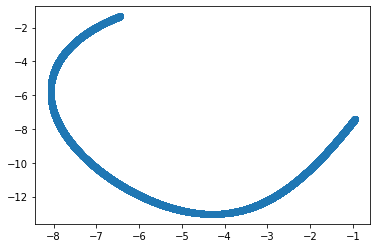

In [80]:
plt.scatter(GD1_track6D.track.pm_ra_cosdec.value, GD1_track6D.track.pm_dec.value)

In [145]:
GD1_track6D.track.transform_to(GD1_track6D.stream_frame)

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (34.78577978, 29.13133332, 1.)>, center=None, ra0=148.14590426569234 deg, rotation=0.0 deg): (phi1, phi2, distance) in (deg, deg, kpc)
    [(-51.13389982, -3.58965841,  9.19913413),
     (-51.12388038, -3.58818108,  9.19864732),
     (-51.11386095, -3.58670409,  9.1981605 ), ...,
     ( 51.12445608, -2.84931405, 11.68099538),
     ( 51.13447552, -2.85036334, 11.68271884),
     ( 51.14449495, -2.85141279, 11.68444274)]
 (pm_phi1_cosphi2, pm_phi2, radial_velocity) in (mas / yr, mas / yr, km / s)
    [(-6.9443532 , -2.75297379,  3.04200213e-13),
     (-6.94732263, -2.75358691,  7.05239247e-14),
     (-6.9502913 , -2.75419976,  1.83151685e-13), ...,
     (-6.3275544 , -1.83379602,  8.63128631e-14),
     (-6.32531066, -1.83365095,  7.47343083e-14),
     (-6.32306666, -1.83350599, -1.47363425e-14)]>

In [146]:
mwsts

{'20.0-1-M18': <galstreams.Track6D at 0x7fd240108390>,
 '300S-F18': <galstreams.Track6D at 0x7fd24152bcd0>,
 'AAU-AliqaUma-L21': <galstreams.Track6D at 0x7fd24152f8d0>,
 'AAU-ATLAS-L21': <galstreams.Track6D at 0x7fd23f7e1950>,
 'Acheron-G09': <galstreams.Track6D at 0x7fd23f7c2ed0>,
 'ACS-R21': <galstreams.Track6D at 0x7fd241537a50>,
 'Alpheus-G13': <galstreams.Track6D at 0x7fd242f29950>,
 'Aquarius-W11': <galstreams.Track6D at 0x7fd242f28fd0>,
 'C-19-I21': <galstreams.Track6D at 0x7fd24492fd90>,
 'C-4-I21': <galstreams.Track6D at 0x7fd24492a2d0>,
 'C-5-I21': <galstreams.Track6D at 0x7fd24010ca90>,
 'C-7-I21': <galstreams.Track6D at 0x7fd23f7c5e90>,
 'C-8-I21': <galstreams.Track6D at 0x7fd244224690>,
 'C-9-I21': <galstreams.Track6D at 0x7fd23f7c5f50>,
 'Cetus-New-Y21': <galstreams.Track6D at 0x7fd24151e050>,
 'Cetus-Palca-T21': <galstreams.Track6D at 0x7fd242d30c90>,
 'Cetus-Y13': <galstreams.Track6D at 0x7fd24153ee10>,
 'Cocytos-G09': <galstreams.Track6D at 0x7fd23b260990>,
 'Corvus-M1

Generate random points on the sphere in an area around the track

In [135]:
GD1_track6D = mwsts['GD-1-I21']
GD1_track = GD1_track6D.track
GD1_track_frame = GD1_track.transform_to(GD1_track6D.stream_frame)

phi1o, phi1f = np.min(GD1_track_frame.phi1.deg), np.max(GD1_track_frame.phi1.deg)
phi2o, phi2f = np.min(GD1_track_frame.phi2.deg), np.max(GD1_track_frame.phi2.deg)

#rao,raf = np.min(p.track.track.ra.deg), np.max(p.track.track.ra.deg) # need to wrap for Jhelum
rao,raf = np.min(p.track.track.ra.wrap_at(180*u.deg).deg), np.max(p.track.track.ra.wrap_at(180*u.deg).deg)
deco,decf = np.min(p.track.track.dec.deg),np.max(p.track.track.dec.deg)
field_ra, field_dec = gst.get_random_spherical_angles(5000,az=[rao,raf],
                                                           lat=[deco,decf],degree=True)
field = SkyCoord(ra=field_ra*u.deg, dec=field_dec*u.deg, frame='icrs')

In [136]:
p.skyprint['stream'].edges

<SkyCoord (GreatCircleICRSFrame: pole=<ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
    (34.78577978, 29.13133332, 1.)>, center=None, ra0=148.14590426569234 deg, rotation=0.0 deg): (phi1, phi2) in deg
    [(-51.13389982, -2.58965841), (-51.12388038, -2.58818108),
     (-51.11386095, -2.58670409), ..., (-51.11386095, -4.58670409),
     (-51.12388038, -4.58818108), (-51.13389982, -4.58965841)]>

In [137]:
p = Pawprint.pawprint_from_galstreams('GD-1','ibata2021')

In [138]:
p.skyprint['stream'].vertices[::100]

array([[-5.11338998e+01, -2.58965841e+00],
       [-5.01319563e+01, -2.44356088e+00],
       [-4.91300128e+01, -2.30075519e+00],
       [-4.81280693e+01, -2.16122502e+00],
       [-4.71261257e+01, -2.02495408e+00],
       [-4.61241822e+01, -1.89192603e+00],
       [-4.51222387e+01, -1.76212458e+00],
       [-4.41202952e+01, -1.63553339e+00],
       [-4.31183516e+01, -1.51213618e+00],
       [-4.21164081e+01, -1.39191661e+00],
       [-4.11144646e+01, -1.27485837e+00],
       [-4.01125211e+01, -1.16094516e+00],
       [-3.91105775e+01, -1.05016066e+00],
       [-3.81086340e+01, -9.42488557e-01],
       [-3.71066905e+01, -8.37912537e-01],
       [-3.61047470e+01, -7.36416287e-01],
       [-3.51028035e+01, -6.37983495e-01],
       [-3.41008599e+01, -5.42597847e-01],
       [-3.30989164e+01, -4.50243030e-01],
       [-3.20969729e+01, -3.60902732e-01],
       [-3.10950294e+01, -2.74560638e-01],
       [-3.00930858e+01, -1.91200436e-01],
       [-2.90911423e+01, -1.10805813e-01],
       [-2.

In [139]:
pm_poly = [[-9, -2], [-9, 0.5], [-4, 1.5], [-4, -1]]
p.pmprint = Footprint2D(pm_poly, footprint_type='cartesian')

In [140]:
p.pmprint.vertices

[[-9, -2], [-9, 0.5], [-4, 1.5], [-4, -1]]

generate masks for the on- and off-stream sky footprints

In [141]:
on = p.skyprint['stream'].inside_footprint(field)
off = p.skyprint['background'].inside_footprint(field)

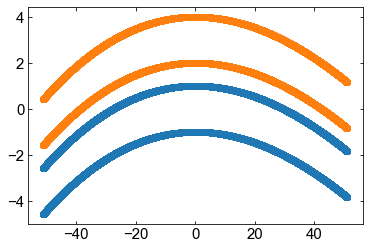

In [142]:
plt.scatter(p.skyprint['stream'].edges.phi1.value,
            p.skyprint['stream'].edges.phi2.value)
plt.scatter(p.skyprint['background'].edges.phi1.value,
            p.skyprint['background'].edges.phi2.value)

plot things in equatorial coordinates

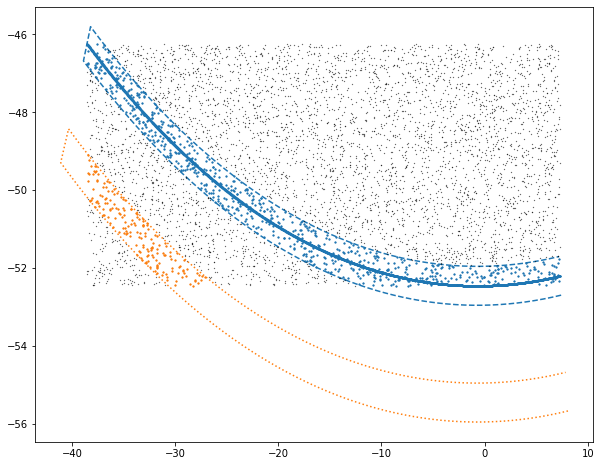

In [14]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#plot the track
#ax.plot(p.track.track.ra.wrap_at(180*u.deg), p.track.track.dec, '.', ms=2., color='C0') # because already wrapped
ax.plot(p.track.track.ra, p.track.track.dec, '.', ms=2., color='C0')

#plot the on-stream polygon
ax.plot(p.skyprint['stream'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['stream'].edges.icrs.dec, ls='--', color='C0')

#plot random background "field" points 
ax.plot(field.ra.wrap_at(180*u.deg), field.dec, 'k.', ms=0.5)

#plot the field points inside the polygon footprint
ax.plot(field.ra[on].wrap_at(180*u.deg), field.dec[on], '.', ms=2.5, color='C0')

#Plot the off-stream polygon footprint and points selected inside it
ax.plot(p.skyprint['background'].edges.icrs.ra.wrap_at(180*u.deg), p.skyprint['background'].edges.icrs.dec, ls=':', color='C1')
ax.plot(field.ra[off].wrap_at(180*u.deg), field.dec[off], '.', ms=2.5, color='C1')

plot things in stream coordinates

(-10.0, 10.0)

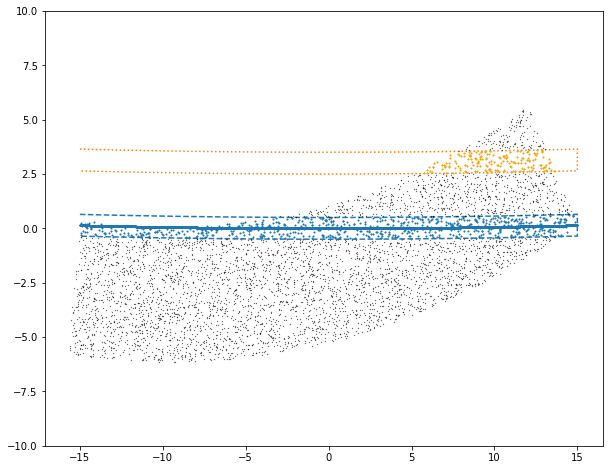

In [15]:

plt.figure(1,figsize=(10,8))
ax = plt.subplot(111)

#Plot the track in phi1/phi2
ax.plot(p.track.track.transform_to(p.stream_frame).phi1, 
        p.track.track.transform_to(p.stream_frame).phi2, '.', ms=2., color='C0')
#plot the on-stream polygon 
ax.plot(p.skyprint['stream'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['stream'].edges.transform_to(p.stream_frame).phi2, ls='--', color='C0')
#plot the off-stream polygon
ax.plot(p.skyprint['background'].edges.transform_to(p.stream_frame).phi1, 
        p.skyprint['background'].edges.transform_to(p.stream_frame).phi2, ls=':', color='C1')

ax.plot(field.transform_to(p.stream_frame).phi1, field.transform_to(p.stream_frame).phi2,'.k', ms=0.5)
ax.plot(field[on].transform_to(p.stream_frame).phi1, field[on].transform_to(p.stream_frame).phi2,'.', ms=2)
ax.plot(field[off].transform_to(p.stream_frame).phi1, field[off].transform_to(p.stream_frame).phi2,'.', color='orange', ms=2)

ax.set_ylim(-10,10)

save the pawprint

In [8]:
p.save_pawprint()

/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/schema.py:301: AsdfWarning: Unable to locate schema file for 'tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0': 'http://astropy.org/schemas/astropy/coordinates/frames/greatcircleicrsframe-1.0.0'
  warnings.warn(msg.format(tag, schema_uri), AsdfWarning)


if you want to inspect the pawprint directly you can load it with asdf or astropy's asdf reader

In [9]:
import asdf
a = asdf.open('Jhelum-abonaca2019.asdf')

/opt/anaconda3/envs/cats/lib/python3.8/site-packages/asdf/yamlutil.py:300: AsdfConversionWarning: tag:astropy.org:astropy/coordinates/frames/greatcircleicrsframe-1.0.0 is not recognized, converting to raw Python data structure
  warnings.warn(


all the bits are in a dictionary

In [10]:
a.keys()

dict_keys(['asdf_library', 'history', 'cmd_filters', 'off_stream', 'on_stream', 'pawprint_ID', 'stream_frame', 'stream_name', 'width'])

In [11]:
a['stream_name']

'Jhelum-a'

In [12]:
a['on_stream']['sky']

{'footprint_type': 'sky',
 'stream_frame': {'frame_attributes': {'pole': <ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
     (178.37247005, -37.60347959, 1.)>, 'ra0': <Quantity 342.9753055 deg>, 'rotation': <Quantity 0. deg>}},
 'vertices': <array (unloaded) shape: [6000, 2] dtype: float64>}

In [13]:
a['off_stream']

{'footprint_type': 'sky',
 'stream_frame': {'frame_attributes': {'pole': <ICRS Coordinate: (ra, dec, distance) in (deg, deg, kpc)
     (178.37247005, -37.60347959, 1.)>, 'ra0': <Quantity 342.9753055 deg>, 'rotation': <Quantity 0. deg>}},
 'vertices': <array (unloaded) shape: [6000, 2] dtype: float64>}

right now this pawprint doesn't have any CMD footprints:

In [14]:
a['on_stream']['cmd']

or any PM footprints:

In [15]:
a['on_stream']['pm']

In [16]:
print(a['cmd_filters'])

None
